In [1]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams

%matplotlib inline

In [2]:
# загружаем данные о заказах в табличку
# визуализации данных в ноутбуке с аримаксом

orders = pd.read_csv('train.csv', sep =',').dropna()

orders['date'] = pd.to_datetime(orders.date,format='%d.%m.%Y') 
orders.drop('date_id', axis = 1, inplace = True)

orders.rename(columns={'date':'ds', 'orders':'y'}, inplace=True)

train_orders = orders.sort_values('ds', ascending = True)

train_orders.head(5)

,ds,y
0,2018-12-27,17
1,2018-12-28,29
2,2018-12-29,30
3,2018-12-30,24
4,2018-12-31,11


In [3]:
# метрика качества MAPE

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

model = Prophet()
model.fit(train_orders)

/usr/local/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [4]:
# предсказываем на нужное количество дней вперед

future = model.make_future_dataframe(periods=9)
future.tail()

,ds
100,2019-04-06
101,2019-04-07
102,2019-04-08
103,2019-04-09
104,2019-04-10


In [7]:
forecast = model.predict(future)
cv_results = cross_validation(model, horizon='7 days', period='7 days', initial='21 days')

mape_baseline = mape(cv_results.y, cv_results.yhat)
mape_baseline

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-03-18 00:00:00 and 2019-03-25 00:00:00


16.937119356702482

In [10]:
period = [7, 14]
fourier_order = [7, 9, 11, 13]
best_mape = float("inf")

parameters = product(period, fourier_order)
parameters_list = list(parameters)
len(parameters_list)

8

In [12]:
from itertools import product

for param in parameters_list:
    try:
        model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False).add_seasonality(name='weekly',
                                                                                                                    period=param[0],
                                                                                                                    fourier_order=param[1])
        model.fit(train_orders)
        cv_results = cross_validation(model, horizon='7 days', period='7 days', initial='21 days')
        mape = mape(cv_results.y, cv_results.yhat)
    except:
        pass
    
    if mape < best_mape:
        best_model = model
        best_mape = mape

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-01-21 00:00:00 and 2019-03-25 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.0.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-01-21 00:00:00 and 2019-03-25 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.0.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-01-21 00:00:00 and 2019-03-25 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.0.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-01-21 00:00:00 and 2019-03-25 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.0.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-01-21 00:00:00 and 2019-03-25 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.0.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-01-21 00:00:00 and 2019-03-25 00:00:00
INFO:fbpro

In [13]:
best_mape

17.508642657073263

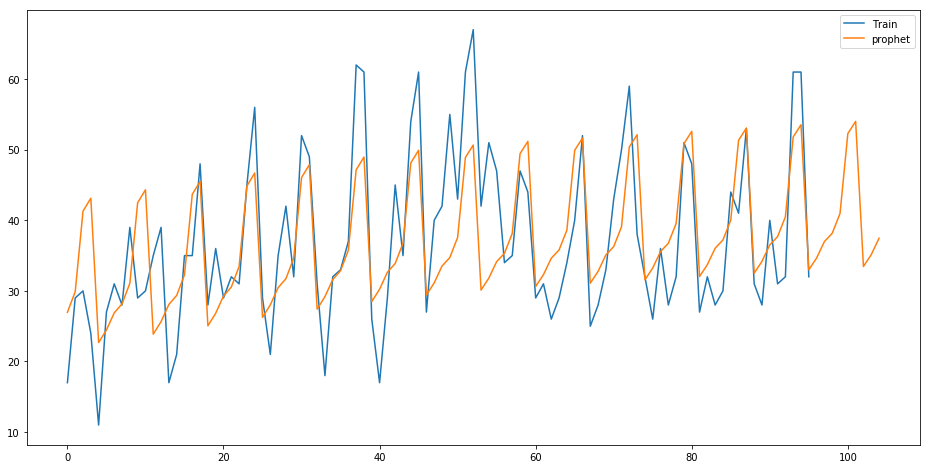

In [14]:
forecast = best_model.predict(future)

plt.figure(figsize=(16,8))
plt.plot(orders.y, label='Train')
plt.plot(forecast.yhat, label='prophet')
plt.legend(loc='best')
plt.show()

In [15]:
ans = forecast.yhat[97:]
df = pd.DataFrame({'date_id': [97, 98, 99, 100, 101, 102, 103, 104],
                    'orders': forecast.yhat[97:]})
df

,date_id,orders
97,97,36.989501
98,98,38.163126
99,99,40.968517
100,100,52.276657
101,101,54.012664
102,102,33.458250
103,103,35.133657
104,104,37.462275


In [16]:
df.to_csv('submit_prophet.csv', index=False)